# Time Series Forecasting

## Goal

Your goal is to implement the model that predicts the stock prices using rolling window.


## tsfresh

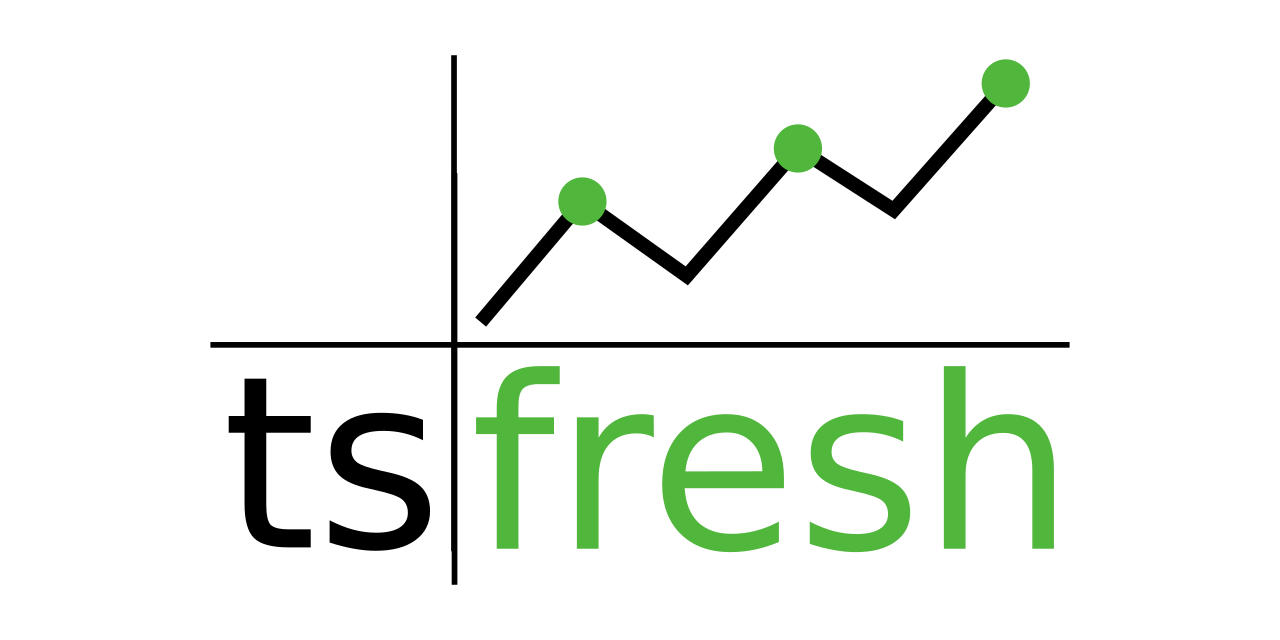

The tsfresh Python library is a tool for automated feature extraction from time series data. It is designed to help users extract a large number of features from time series datasets, which can then be used for various machine learning tasks such as classification, regression, and clustering. The library is particularly useful when dealing with time series data that may have complex patterns and relationships that are not immediately obvious.

Let us install the tsfresh and its dependencies:

In [1]:
!pip install tsfresh
!pip install dask[dataframe]

## Data Loading and Preparing

Import pandas and numpy to load and prepare the data:

In [2]:
import pandas as pd
import numpy as np

Load the training data:

In [3]:
df = pd.read_csv('/kaggle/input/pmldl-week-14-time-series-forecasting/train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Price
0,2019-11-29,115.890
1,2019-12-02,114.563
2,2019-12-03,113.870
3,2019-12-04,113.773
4,2019-12-05,113.704
...,...,...
773,2022-12-23,141.650
774,2022-12-27,142.420
775,2022-12-28,140.020
776,2022-12-29,141.060


Now we create an `id` column. Later it will be clear why we do it. But, generally, tsfresh will use this column do distinguish various windows with values:

In [4]:
df["id"] = 'id'
df

,Date,Price,id
0,2019-11-29,115.890,id
1,2019-12-02,114.563,id
2,2019-12-03,113.870,id
3,2019-12-04,113.773,id
4,2019-12-05,113.704,id
...,...,...,...
773,2022-12-23,141.650,id
774,2022-12-27,142.420,id
775,2022-12-28,140.020,id
776,2022-12-29,141.060,id


## Visualizing Time Series

Take a look at the series:

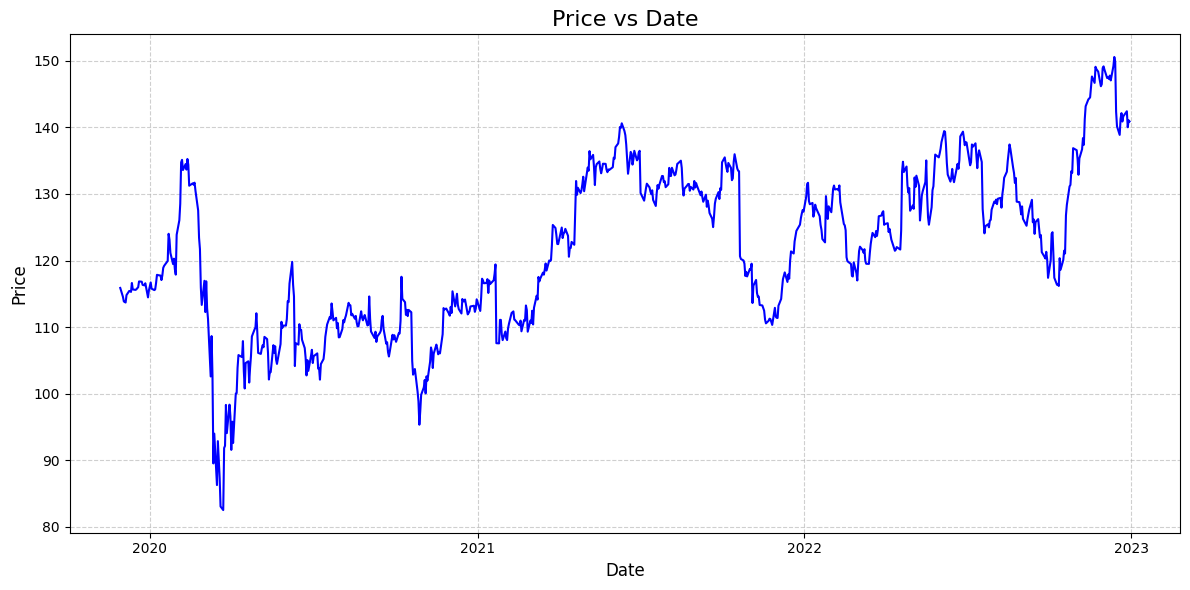

In [5]:
import matplotlib.pyplot as plt

# Plotting the Price vs Date
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='blue')

# Setting ticks at yearly intervals
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Adding titles and labels
plt.title('Price vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

## Time Series Rolling

Now we need to create the training samples from the series. It can be done by taking the values from the series within a certain window of a specified size. The values from the window will be used to predict the next values that go after the window.

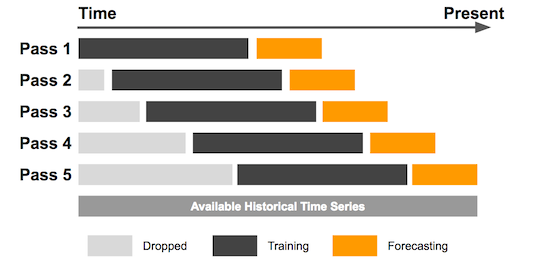

This rolling can be done with `roll_time_series` from tsfresh. [Here](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) is the description of how it works.

In [6]:
from tsfresh.utilities.dataframe_functions import roll_time_series

# Set the window size
window_size = 5

# Roll the time series with roll_time_series
df_rolled = roll_time_series(df, column_id="id", column_sort="Date", max_timeshift= window_size)


/opt/conda/lib/python3.10/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 10/10 [00:00<00:00, 18.77it/s]


Let's see what we've got:

In [7]:
df_rolled

,Date,Price,id
468,2019-11-29,115.890,"(id, 2019-11-29 00:00:00)"
469,2019-11-29,115.890,"(id, 2019-12-02 00:00:00)"
470,2019-12-02,114.563,"(id, 2019-12-02 00:00:00)"
471,2019-11-29,115.890,"(id, 2019-12-03 00:00:00)"
472,2019-12-02,114.563,"(id, 2019-12-03 00:00:00)"
...,...,...,...
4648,2022-12-23,141.650,"(id, 2022-12-30 00:00:00)"
4649,2022-12-27,142.420,"(id, 2022-12-30 00:00:00)"
4650,2022-12-28,140.020,"(id, 2022-12-30 00:00:00)"
4651,2022-12-29,141.060,"(id, 2022-12-30 00:00:00)"


`id` is used to indicate rows that belong to the same window

In [8]:
df_rolled[df_rolled["id"] == ("id", pd.to_datetime("2022-12-30"))]

,Date,Price,id
4647,2022-12-22,140.88,"(id, 2022-12-30 00:00:00)"
4648,2022-12-23,141.65,"(id, 2022-12-30 00:00:00)"
4649,2022-12-27,142.42,"(id, 2022-12-30 00:00:00)"
4650,2022-12-28,140.02,"(id, 2022-12-30 00:00:00)"
4651,2022-12-29,141.06,"(id, 2022-12-30 00:00:00)"
4652,2022-12-30,140.89,"(id, 2022-12-30 00:00:00)"


## Features Extraction

Now, after we sampled the values for different windows we can create predicting features.

The features can be created with `extract_features`. Basically, it takes the samples from the window and calculates various statistics and indicator variables from the samples. These features include `sum_values`, `abs_energy`, `mean_abs_change`, `mean_second_derivative_central`, etc. In total, it creates 783 features.

The documentation for `extract_features` is [here](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.extraction).

In [9]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

# Create feature with extract_features
# Create features with extract_features
X = extract_features(df_rolled, column_id="id", column_sort="Date")

# Handle missing values in the extracted features


Feature Extraction: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Take a look at what features has been created:

In [10]:
X = impute(X)

X


/opt/conda/lib/python3.10/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Price__autocorrelation__lag_6' 'Price__autocorrelation__lag_7'
 'Price__autocorrelation__lag_8' 'Price__autocorrelation__lag_9'
 'Price__partial_autocorrelation__lag_3'
 'Price__partial_autocorrelation__lag_4'
 'Price__partial_autocorrelation__lag_5'
 'Price__partial_autocorrelation__lag_6'
 'Price__partial_autocorrelation__lag_7'
 'Price__partial_autocorrelation__lag_8'
 'Price__partial_autocorrelation__lag_9'
 'Price__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)'
 'Price__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)'
 'Price__cwt_coeff

Price__variance_larger_than_standard_deviation  \
id 2019-11-29                                             0.0   
   2019-12-02                                             0.0   
   2019-12-03                                             0.0   
   2019-12-04                                             0.0   
   2019-12-05                                             0.0   
...                                                       ...   
   2022-12-23                                             1.0   
   2022-12-27                                             1.0   
   2022-12-28                                             0.0   
   2022-12-29                                             0.0   
   2022-12-30                                             0.0   

               Price__has_duplicate_max  Price__has_duplicate_min  \
id 2019-11-29                       0.0                       0.0   
   2019-12-02                       0.0                       0.0   
   2019-12-03                       0.0                       0.0   
   2019-12-04                       0.0                       0.0   
   2019-12-05                       0.0                       0.0   
...                                 ...                       ...   
   2022-12-23                       0.0                       0.0   
   2022-12-27                       0.0                       0.0   
   2022-12-28                       0.0                       0.0   
   2022-12-29                       0.0                       0.0   
   2022-12-30                       0.0                       0.0   

               Price__has_duplicate  Price__sum_values  Price__abs_energy  \
id 2019-11-29                   0.0            115.890       13430.492100   
   2019-12-02                   0.0            230.453       26555.173069   
   2019-12-03                   0.0            344.323       39521.549969   
   2019-12-04                   0.0            458.096       52465.845498   
   2019-12-05                   0.0            571.800       65394.445114   
...                             ...                ...                ...   
   2022-12-23                   0.0            844.980      119005.417400   
   2022-12-27                   0.0            847.240      119644.048200   
   2022-12-28                   0.0            848.390      119964.771700   
   2022-12-29                   0.0            848.170      119902.656900   
   2022-12-30                   0.0            846.920      119548.869400   

               Price__mean_abs_change  Price__mean_change  \
id 2019-11-29                1.243200            0.066200   
   2019-12-02                1.327000           -1.327000   
   2019-12-03                1.010000           -1.010000   
   2019-12-04                0.705667           -0.705667   
   2019-12-05                0.546500           -0.546500   
...                               ...                 ...   
   2022-12-23                1.318000            0.298000   
   2022-12-27                1.214000            0.710000   
   2022-12-28                1.212000           -0.252000   
   2022-12-29                1.248000           -0.216000   
   2022-12-30                1.030000            0.002000   

               Price__mean_second_derivative_central  Price__median  ...  \
id 2019-11-29                               0.000000       115.8900  ...   
   2019-12-02                               0.000000       115.2265  ...   
   2019-12-03                               0.317000       114.5630  ...   
   2019-12-04                               0.307500       114.2165  ...   
   2019-12-05                               0.209667       113.8700  ...   
...                                              ...            ...  ...   
   2022-12-23                               0.257500       141.0800  ...   
   2022-12-27                              -0.205000       141.4650  ...   
   2022-12-28                              -0.407500       141.

Notice, that the features dataframe has a complex index. We don't need it, so we get rid of `id` index and leave `Date` as the index.

In [11]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "Date"
X.head()

,Price__variance_larger_than_standard_deviation,Price__has_duplicate_max,Price__has_duplicate_min,Price__has_duplicate,Price__sum_values,Price__abs_energy,Price__mean_abs_change,Price__mean_change,Price__mean_second_derivative_central,Price__median,...,Price__fourier_entropy__bins_5,Price__fourier_entropy__bins_10,Price__fourier_entropy__bins_100,Price__permutation_entropy__dimension_3__tau_1,Price__permutation_entropy__dimension_4__tau_1,Price__permutation_entropy__dimension_5__tau_1,Price__permutation_entropy__dimension_6__tau_1,Price__permutation_entropy__dimension_7__tau_1,Price__query_similarity_count__query_None__threshold_0.0,Price__mean_n_absolute_max__number_of_maxima_7
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29,0.0,0.0,0.0,0.0,115.890,13430.492100,1.243200,0.066200,0.000000,115.8900,...,1.039721,1.039721,1.386294,1.039721,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-02,0.0,0.0,0.0,0.0,230.453,26555.173069,1.327000,-1.327000,0.000000,115.2265,...,-0.000000,-0.000000,-0.000000,1.039721,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-03,0.0,0.0,0.0,0.0,344.323,39521.549969,1.010000,-1.010000,0.317000,114.5630,...,0.693147,0.693147,0.693147,-0.000000,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-04,0.0,0.0,0.0,0.0,458.096,52465.845498,0.705667,-0.705667,0.307500,114.2165,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,0.693147,0.0,0.0,0.0,0.0
2019-12-05,0.0,0.0,0.0,0.0,571.800,65394.445114,0.546500,-0.546500,0.209667,113.8700,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0


Create target

In [12]:
# Shift the prices one position back to make the model predict the future values
y = df['Price'].shift(-1)

# Set the index to be the dates from the df dataframe
y.index = df['Date']

# Drop all rows from y that do not exist in X
y = y.loc[X.index]

y


Date
2019-11-29    114.563
2019-12-02    113.870
2019-12-03    113.773
2019-12-04    113.704
2019-12-05    114.817
               ...   
2022-12-23    142.420
2022-12-27    140.020
2022-12-28    141.060
2022-12-29    140.890
2022-12-30        NaN
Name: Price, Length: 778, dtype: float64

Notice that the targets series do not have the last value now. We need to drop it from X and y.

In [13]:
# Save the index of the last value in y
last_date = y.index[-1]

# Drop NaN values in y
y = y.dropna()

y


Date
2019-11-29    114.563
2019-12-02    113.870
2019-12-03    113.773
2019-12-04    113.704
2019-12-05    114.817
               ...   
2022-12-22    141.650
2022-12-23    142.420
2022-12-27    140.020
2022-12-28    141.060
2022-12-29    140.890
Name: Price, Length: 777, dtype: float64

Let's do the same for X:

In [14]:
# Drop the last index in X
X = X.drop(index=last_date)

X


,Price__variance_larger_than_standard_deviation,Price__has_duplicate_max,Price__has_duplicate_min,Price__has_duplicate,Price__sum_values,Price__abs_energy,Price__mean_abs_change,Price__mean_change,Price__mean_second_derivative_central,Price__median,...,Price__fourier_entropy__bins_5,Price__fourier_entropy__bins_10,Price__fourier_entropy__bins_100,Price__permutation_entropy__dimension_3__tau_1,Price__permutation_entropy__dimension_4__tau_1,Price__permutation_entropy__dimension_5__tau_1,Price__permutation_entropy__dimension_6__tau_1,Price__permutation_entropy__dimension_7__tau_1,Price__query_similarity_count__query_None__threshold_0.0,Price__mean_n_absolute_max__number_of_maxima_7
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29,0.0,0.0,0.0,0.0,115.890,13430.492100,1.243200,0.066200,0.000000,115.8900,...,1.039721,1.039721,1.386294,1.039721,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-02,0.0,0.0,0.0,0.0,230.453,26555.173069,1.327000,-1.327000,0.000000,115.2265,...,-0.000000,-0.000000,-0.000000,1.039721,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-03,0.0,0.0,0.0,0.0,344.323,39521.549969,1.010000,-1.010000,0.317000,114.5630,...,0.693147,0.693147,0.693147,-0.000000,1.098612,0.693147,0.0,0.0,0.0,0.0
2019-12-04,0.0,0.0,0.0,0.0,458.096,52465.845498,0.705667,-0.705667,0.307500,114.2165,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,0.693147,0.0,0.0,0.0,0.0
2019-12-05,0.0,0.0,0.0,0.0,571.800,65394.445114,0.546500,-0.546500,0.209667,113.8700,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,1.0,0.0,0.0,0.0,845.690,119207.064500,1.604000,-0.296000,0.117500,141.0800,...,0.693147,1.039721,1.386294,1.386294,1.098612,0.693147,-0.0,0.0,0.0,0.0
2022-12-23,1.0,0.0,0.0,0.0,844.980,119005.417400,1.318000,0.298000,0.257500,141.0800,...,1.039721,1.386294,1.386294,1.386294,1.098612,0.693147,-0.0,0.0,0.0,0.0
2022-12-27,1.0,0.0,0.0,0.0,847.240,119644.048200,1.214000,0.710000,-0.205000,141.4650,...,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.0,0.0,0.0,0.0


## Modelling

We have got predictors and target. Now, we can train a regressor to predict the price:

In [15]:
# Create and train the model here...
from prophet import Prophet
import pandas as pd

# Prepare the data for Prophet
# Prophet requires two columns: 'ds' (date) and 'y' (target variable)
prophet_df = pd.DataFrame({'ds': y.index, 'y': y.values})

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(prophet_df)

# Forecast future values
future = model.make_future_dataframe(periods=1)  # Adjust the periods for the desired forecast horizon
forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


21:36:30 - cmdstanpy - INFO - Chain [1] start processing
21:36:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
773,2022-12-23,141.587456,133.902987,149.260670
774,2022-12-27,143.137968,136.215841,150.752410
775,2022-12-28,143.243161,135.770347,150.298325
776,2022-12-29,143.498103,136.211754,151.461702
777,2022-12-30,143.952665,136.894629,151.721057


## Inference

In order to sequentially predict the values we need to write the function which takes the last `window_size` values, creates features and passes them to the model.

In [16]:
# def predict_next_price(prev_values):
#     # Implement the function here...
#     ...
#     pred_value = ...
#     return pred_value

# prev_values = df.sort_values('Date').tail(window_size)
# predict_next_price(prev_values)


from prophet import Prophet
import pandas as pd

def predict_next_price(prev_values):
    # Prepare the data for Prophet
    prophet_df = pd.DataFrame({
        'ds': prev_values['Date'],  # Ensure 'Date' is the timestamp column
        'y': prev_values['Price']  # Replace 'price' with the column name for prices
    })
    
    # Initialize the Prophet model
    model = Prophet()
    
    # Fit the model
    model.fit(prophet_df)
    
    # Create a future DataFrame with one step into the future
    future = model.make_future_dataframe(periods=1)
    
    # Predict the next price
    forecast = model.predict(future)
    pred_value = forecast.iloc[-1]['yhat']  # Get the last prediction value
    
    return pred_value

# Example usage
prev_values = df.sort_values('Date').tail(window_size)  # Replace 'Date' with your actual date column
predict_next_price(prev_values)


21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing


140.49274717218992

Let us read the dates for which we need to predict prices:

In [17]:
df_test = pd.read_csv('/kaggle/input/pmldl-week-14-time-series-forecasting/test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test

,Date
0,2023-01-03
1,2023-01-04
2,2023-01-05
3,2023-01-06
4,2023-01-09
...,...
474,2024-11-20
475,2024-11-21
476,2024-11-22
477,2024-11-25


Predict the prices for the test dates

Now let's visualize the predictions

In [18]:
# from tqdm import tqdm

# # Sort the DataFrame by the "Date" column and extract the sorted dates and prices into lists
# dates = df.sort_values("Date").Date.tolist()
# prices = df.sort_values("Date").Price.tolist()

# # Initialize an empty list to store the predicted prices
# predicted_prices = []

# # Loop through each row in the test DataFrame, with a progress bar using tqdm
# for i in tqdm(range(len(df_test))):

#     # Create a DataFrame with the last 'window_size' dates and prices for prediction
#     ...

#     # Predict the next price using the features DataFrame
#     next_price = ...

#     # Append the test date to the dates list
#     ...

#     # Append the predicted price to the prices list
#     ...

#     # Append the predicted price to the predicted_prices list
#     ...
# Initialize an empty list for predicted prices

# from tqdm import tqdm

# # Sort the DataFrame by the "Date" column and extract the sorted dates and prices into lists
# dates = df.sort_values("Date").Date.tolist()
# prices = df.sort_values("Date").Price.tolist()

# # Initialize an empty list to store the predicted prices
# predicted_prices = []

# # Iterate through the sorted test dates
# for i in tqdm(range(len(dates))):
#     # Prepare a single-row future DataFrame for prediction
#     future = pd.DataFrame({'ds': [dates[i]]})

#     # Predict the price for the current date
#     forecast = model.predict(future)
#     predicted_price = forecast['yhat'].iloc[0]  # Extract the predicted price

#     # Append the predicted price to the list
#     predicted_prices.append(predicted_price)

# # Combine the dates and predicted prices into a DataFrame
# predictions_df = pd.DataFrame({
#     'Date': dates,
#     'Predicted_Price': predicted_prices
# })

# # Display the predictions
# print(predictions_df.head())

In [19]:
from prophet import Prophet
import pandas as pd
from tqdm import tqdm

# Load and preprocess the test dataset
df_test = pd.read_csv('/kaggle/input/pmldl-week-14-time-series-forecasting/test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test.sort_values("Date")  # Sort by date for sequential predictions


# Initialize an empty list to store the predicted prices
predicted_prices = []

# Iteratively predict prices for the test set
for date in tqdm(df_test['Date']):
    # Create a dataframe containing the current date for prediction
    future = pd.DataFrame({'ds': [date]})
    
    # Predict the price for the given date
    forecast = model.predict(future)
    
    # Extract the predicted price ('yhat') and append it to the list
    predicted_prices.append(forecast['yhat'].iloc[0])

# Add the predicted prices to the test DataFrame
df_test['Predicted_Price'] = predicted_prices

# Save or display the predictions
df_test.to_csv('predicted_test_prices.csv', index=False)
print(df_test)


100%|██████████| 479/479 [00:14<00:00, 32.97it/s]

          Date  Predicted_Price
0   2023-01-03       145.082675
1   2023-01-04       145.021847
2   2023-01-05       145.094596
3   2023-01-06       145.355885
4   2023-01-09       145.547655
..         ...              ...
474 2024-11-20       193.436250
475 2024-11-21       193.714655
476 2024-11-22       194.186833
477 2024-11-25       194.996740
478 2024-11-26       195.348142

[479 rows x 2 columns]


In [20]:
len(predicted_prices)

479

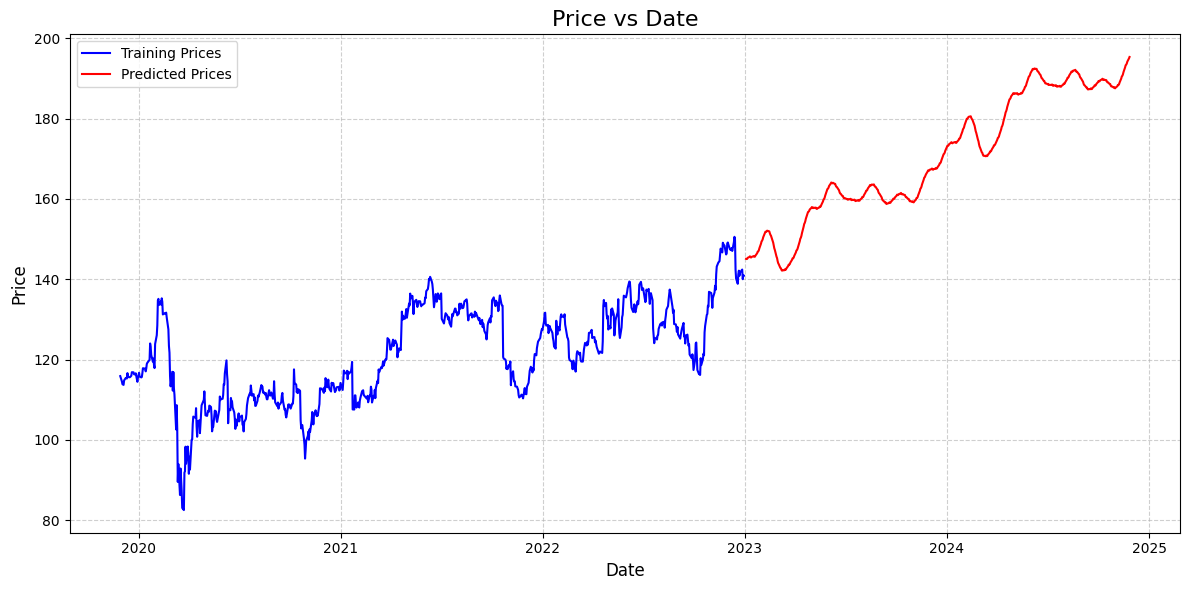

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='blue', label='Training Prices')
plt.plot(df_test['Date'], predicted_prices, color='red', label='Predicted Prices')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.title('Price vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Save the predictions in `submission.csv` file

In [ ]:
df_submission = pd.DataFrame({
    'Date': df_test.Date,
    'Price': predicted_prices
})
df_submission.to_csv('submission.csv', index=False)

When participating in the competition you are not restricted to only the approach with rolling window. You are allowed to try other approaches such as ARIMA, RNN, Prophet. Try them to increase your score.

Good luck!